# Transfer learning with the inception network


## Downloading the network and data

In order to avoid clutter and extraneous technical details, we have created a supplementary module  `transfer_learning.py` that does most of the heavy lifting. We have only exposed the high-level which you are responsible for completing and understanding in full in this notebook.  While you are encouraged to read `transfer_learning.py`, you should not need to modify it in any way.

In [2]:
import tensorflow as tf
import numpy as np
import os
import os.path
import transfer_learning  # This module contains large amounts of pre-written code

We will be using tensorboard to visualize the network, inputs, and other summaries of the training process. After running the following cell, start the server by executing ```tensorboard --logdir=./tmp/inception_v3_log``` from the current folder with the command line and navigate to http://localhost:6006/ in a new browser window. 

In [3]:
# Ensure target log dir exists
INCEPTION_LOG_DIR = './tmp/inception_v3_log'
if not os.path.exists(INCEPTION_LOG_DIR):
    os.makedirs(INCEPTION_LOG_DIR)

In [4]:
# For performance reasons, we only use 100 images per class.
training_images, testing_images, label_maps = transfer_learning.create_image_lists(
    '/Users/zehaodong/Desktop/AML_HW_4/data/flower_photos', testing_percentage=10, max_number_images=100)

INFO:tensorflow:Looking for images in 'roses'
INFO:tensorflow:Looking for images in 'sunflowers'
INFO:tensorflow:Looking for images in 'daisy'
INFO:tensorflow:Looking for images in 'dandelion'
INFO:tensorflow:Looking for images in 'tulips'


Next, we will load the pre-trained inception model and look at its architecture in tensorboard. 

#### 1). Complete the following code block by opening a filewriter and pass it the graph object we have created.

In [5]:
# Create the inception model.
# Warning! The first time you run this, it will try to download the inception model
# from the internet. This is somewhat large (80MB), and can sometimes fail. If
# it does, simply try again.


graph, bottleneck, resized_input, softmax = transfer_learning.create_model()

In [7]:
# Use a summary writer to write the loaded graph and display it in tensorboard.
# Thens answer the questions below

with graph.as_default():
    jpeg_data, decoded_image = transfer_learning.make_jpeg_decoding()

    sess=tf.Session()
    writer= tf.summary.FileWriter("./tmp/inception_v3_log")
    writer.add_graph(sess.graph)


In [40]:
print(decoded_image)

Tensor("Mul_1:0", shape=(1, 299, 299, 3), dtype=float32)


In [41]:
print(bottleneck)
print(resized_input)
print(softmax)

Tensor("pool_3/_reshape:0", shape=(1, 2048), dtype=float32)
Tensor("Mul:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("softmax:0", shape=(1, 1008), dtype=float32)


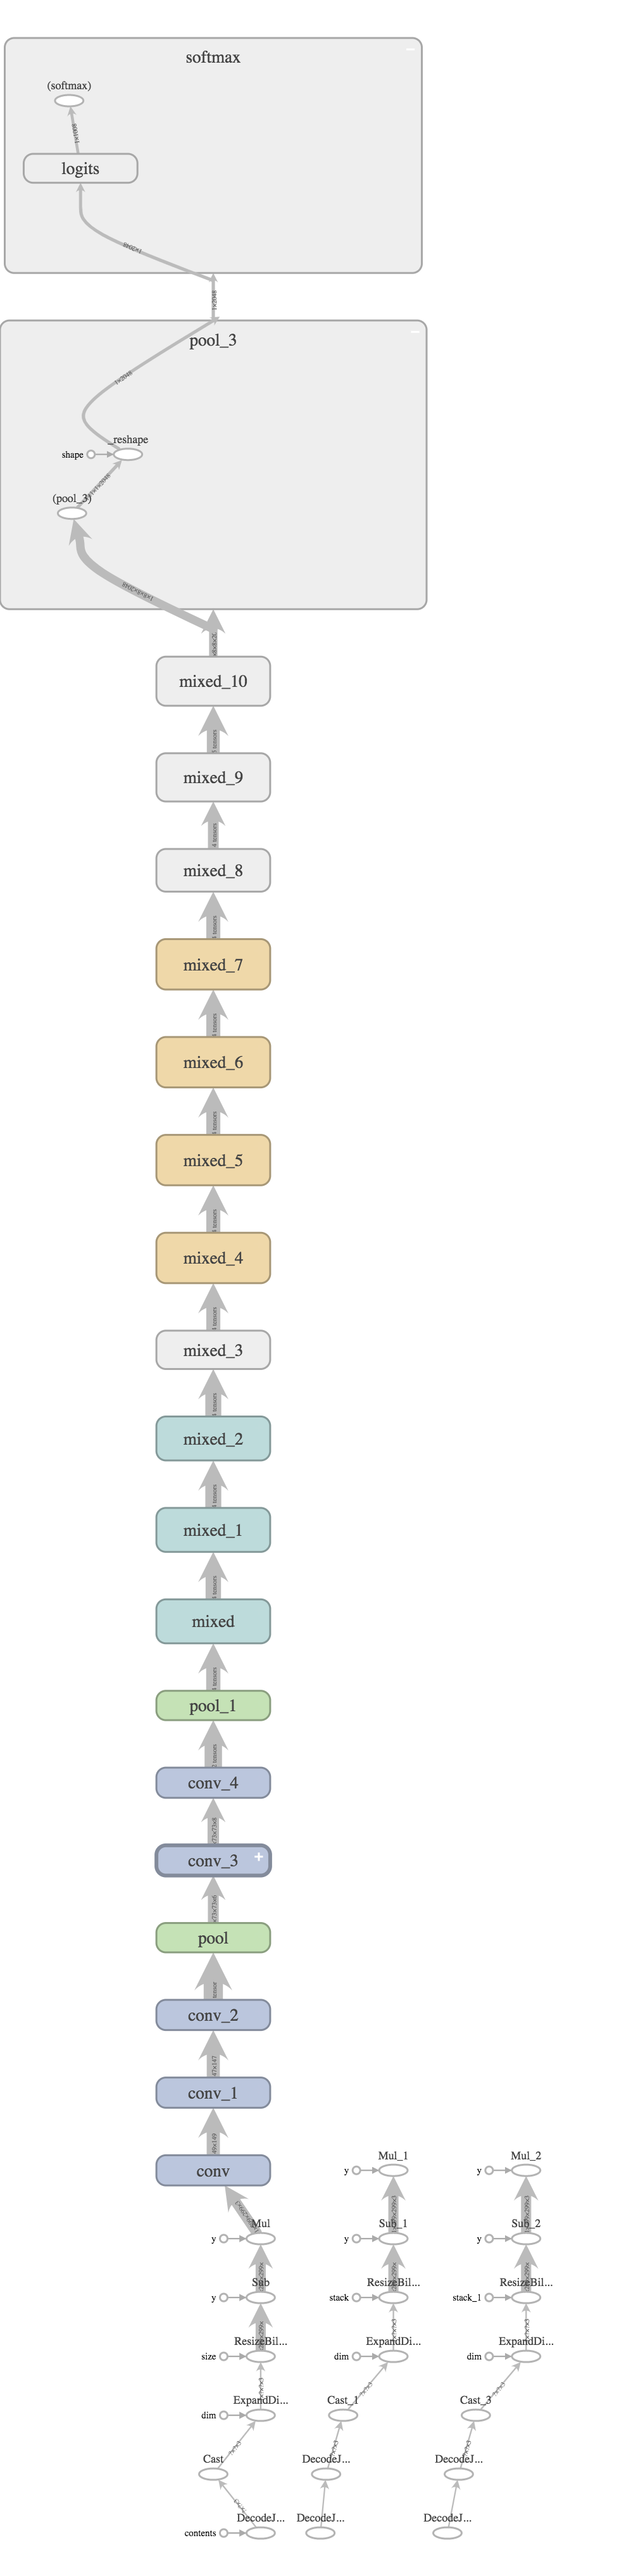

In [8]:
from PIL import Image
Image.open('/Users/zehaodong/Desktop/AML_HW_4/tb1.png')

Support your answers by including screenshots from tensorboard. (to insert images, simply copy and paste into the notebook)

## Classifying out of the box

Before retraining or modifying the network, we would like to better understand how it behaves on our dataset out of the box. Therefore, we will use it classify a couple of our flower images. First, we must create summary operations to write quanities of interest to tensorboard so that we may investigate. 

#### 3.) Complete the block below by implementing the following summaries:
* `output_summary`: a summary of output probabilities (histogram of the output of the softmax block)
* `input_summary`: a summary of image input to the network (image of resized and decoded jpeg data)
* `bottleneck_summary`: a summary of bottleneck activations (histogram of the input to the softmax block)

In [9]:
with graph.as_default():
    # Define summaries for tensorboard
    #-- Students complete
    
    ### YOUR CODE HERE ###
    # 1. add histogram summary which can be used to vsualize distribution
    ## outpurt
    tf.summary.histogram('output_summary',softmax)
    ## bottleneck
    tf.summary.histogram('bottleneck_summary',bottleneck)
    # add image summary to contain images
    tf.summary.image('input_summary',resized_input)
    
    #-- 
    summary_op = tf.summary.merge_all()

Next, we will need a function that streamlines the process of performing inference given an image. This function will take as input the tensorflow session, a path to the image, and the ```summary_op``` we have created above. It will then open a ```t.summary.FileWriter``` and run the network forwards to obtain the formatted image, softmax output, and summaries. 

#### 4). Complete the code block below as instructed in each of the comments.

In [12]:
def classify_image(session, image_path, summary_op):
    """This functions reads a single image from disk and classifies
    the image using the pre-trained network.
    
    Parameters
    ----------
    session: the tensorflow session to use to run the operation
    image_path: a string corresponding to the path of the image to load
    summary_op: the summary operation.
    
    Returns
    -------
    label: an integer representing the label of the classified example.
    softmax_output: the network's output multinomial probabilities
    """
    
    # Open single image file and extract data
    with open(image_path, 'rb') as f:
        image_data = f.read()
        
    
    summary_writer = tf.summary.FileWriter('/Users/zehaodong/Desktop/AML_HW_4/tmp/inception_v3_log',session.graph)
    
    input_for_softmax = session.run(decoded_image, feed_dict={jpeg_data:image_data})
    #bottleneck_value=session.run(bottleneck,feed_dict={resized_input:input_for_softmax})
    softmax_output, summary=session.run((softmax,summary_op),feed_dict={resized_input:input_for_softmax})
    summary_writer.add_summary(summary)
    
    return(np.argmax(softmax_output),softmax_output)

We are now ready to classify some images. Run the code in this cell in order to obtain the output label and navigate to tensorboard to look at the histogram and image summaries that have been logged.

In [13]:
image_path = os.path.join(os.getcwd(), 'data', 'flower_photos', 'daisy', '100080576_f52e8ee070_n.jpg')
with graph.as_default():
    with tf.Session() as session:
        # We classify the image and print the label
        imagenet_label,ans = classify_image(session, image_path, summary_op)
print(imagenet_label)


357


#### 5.) Confirm that your code works by taking a screenshot of the input image in tensorboard.

Include your screenshot here.

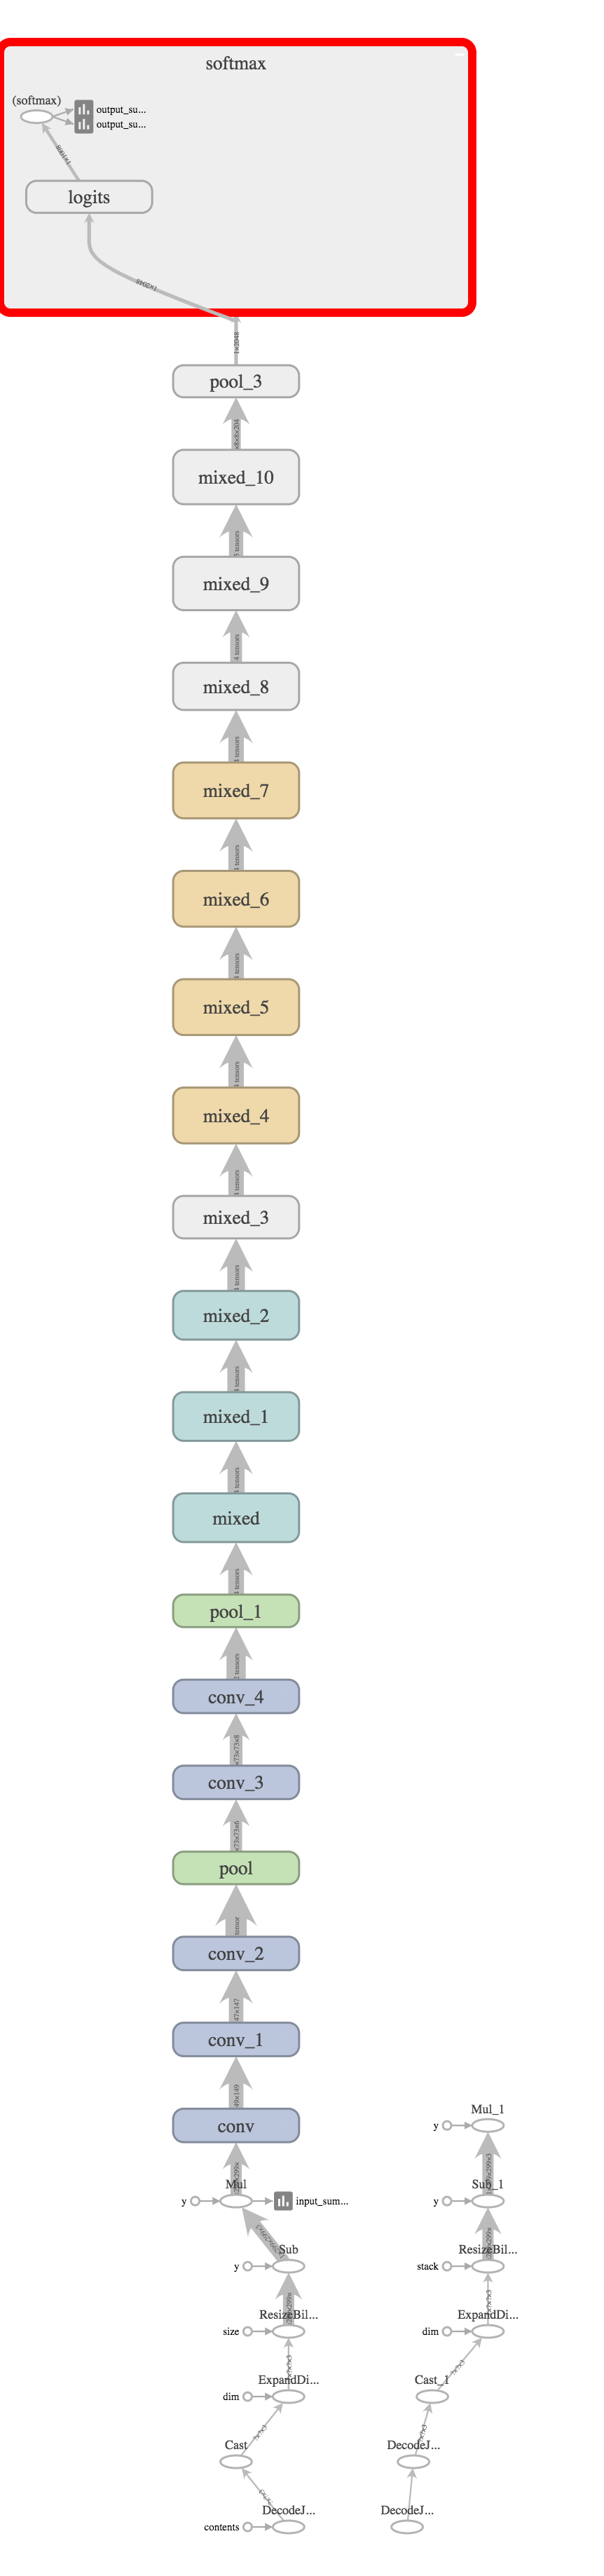

In [16]:
Image.open("tb2.png")

If you've completed the prevous steps correctly, you should see that the pre-trained network assigns the label 357 to our image. Cross referencing this with a [source](https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57) that explains what each of the imagenet labels are, we see that our classifier right on target. The image was indeed a daisy, but this is solely a consequence of the fact that the class 'daisy' is included in the imagenet dataset. We should not expect such favorable outcome when this is not the case. We will test this assumtion by classifying a different type of flower image.

In [17]:
image_path = os.path.join(os.getcwd(), 'data', 'flower_photos', 'roses', '19440805164_920b28da61_n.jpg')
with graph.as_default():
    with tf.Session() as session:
        imagenet_label,softmax_output = classify_image(session, image_path, summary_op)
print(imagenet_label)

874


In [44]:
#Answer these questions here.
#Answer1: The network thinks this is an image of vase(with label of 874). 
#         It is not reasonable
print('Answer2 confidenxe:',softmax_output[0][imagenet_label],'it is not a strong evidence')


Answer2 confidenxe: 0.521832 it is not a strong evidence


## Adapting The Network

Clearly, this model will not suffice for our application out of the box. However, it is not unreasonable to think that we may be able to adapt what this network has "learned" about processing images for our purposes. Remember that the last layer of the network implements a well known classifier (see your answer to question 2). Under this interpretation, the layers of the network up until the last are responsible for learning a non-linear mapping between raw inputs (pixel values) and useful derived features. Consequently, we may remove the last layer, fix the weights of the remaining layers, use what remains as a black-box function transforming images into derived feature vectors, and finally fit a new classifier on the derived feature vectors. 

### Pre-Computing the bottlenecks

To train the new classifier efficiently, we will want to pre-compute the derived feature vectors. We have been calling these the 'bottleneck', because they would limit the speed of training if we had to be re-computed them iteration. Additionally, its small size relative to the dimension of our raw input is essential in ensures that it provides a compact summary of the images for our classifier.

#### 7). Which block in the tensorboard graph is the bottleneck?

Write you answer here.
###  ans: before putting them to the last softmax latyer, the bottle neck layer is the input of the softmax

We have written code that will cache the derived features or 'bottleneck activation' for each images. In order to use this, we require that you complete a simple function that returns these activations.

#### 8). Complete the code block below and compute the bottlenecks.

In [19]:
def compute_bottleneck(session, image_data):
    """Computes the bottleneck for a given image
    
    Parameters
    ----------
    session: the tensorflow session to use for the computation.
    jpeg_data_tensor: the tensor to feed the jpeg data into.
    bottleneck_tensor: the tensor representing.
    image_data: a byte sequence representing the encoded jpeg data.
    
    Returns
    -------
    A numpy array containing the bottleneck information for the image.
    """
    #-- To be completed by the student
    
    ### YOUR CODE HERE ###
    
    jpeg_data_tensor = session.run(decoded_image, feed_dict={jpeg_data:image_data})
    bottleneck_tensor=session.run(bottleneck,feed_dict={resized_input:jpeg_data_tensor})
    return bottleneck_tensor
    
    #--

In [20]:
# This cell generates all the bottlenecks. Warning: it may take a while
# The results are cached so you only need to do it once -- if you change
# your compute_bottleneck function, you will need to delete the existing
# files to force the notebook to regenerate the bottlenecks (they are
# found in ./data/bottlenecks)

with graph.as_default():
    with tf.Session() as session:
        transfer_learning.cache_bottlenecks(compute_bottleneck, session, training_images)

Saved 1/457 bottlenecks
Saved 21/457 bottlenecks
Saved 41/457 bottlenecks
Saved 61/457 bottlenecks
Saved 81/457 bottlenecks
Saved 101/457 bottlenecks
Saved 121/457 bottlenecks
Saved 141/457 bottlenecks
Saved 161/457 bottlenecks
Saved 181/457 bottlenecks
Saved 201/457 bottlenecks
Saved 221/457 bottlenecks
Saved 241/457 bottlenecks
Saved 261/457 bottlenecks
Saved 281/457 bottlenecks
Saved 301/457 bottlenecks
Saved 321/457 bottlenecks
Saved 341/457 bottlenecks
Saved 361/457 bottlenecks
Saved 381/457 bottlenecks
Saved 401/457 bottlenecks
Saved 421/457 bottlenecks
Saved 441/457 bottlenecks
Done computing bottlenecks!


Now that these have been saved, we can load them in a format that is ammenable to use by tensorflow.

In [21]:
# This loads the training data as a matrix of training examples
# and a vector of labels
training_data_set = transfer_learning.create_training_dataset(training_images)

### Training the classifier

We are finally ready to train the new classifier. This is equivalent to replacing & retraining the final layer of our original network with a different number of output classes, so we will still be using tensorflow.

#### 9). Complete the following function as instructed in the comments by:
* Creating a new dense layer of weights, biases, and logits.
* Computing/summarizing the cross-entropy loss.
* Creating an optimizer/training step.

In [22]:
def make_final_layers(bottleneck_tensor, num_classes):
    """Create the operations for the last layer of the network to be retrained.
    
    This function should implement a logistic regression layer from the bottleneck
    to the labels, trained using gradient descent. We have created the inputs
    bottleneck_input and label_input for you. You are responsible for implementing
    the logistic regression layer itself (as you have seen in lecture),
    the predicted_output (predicted probability for each class), the cross entropy
    loss, and the optimization and subsequent training step operation (an
    operation that executes one step of gradient descent).  Note: be careful to
    use the numerically stable implementation of cross entropy loss as discussed
    in lecture.
    
    You should also record a summary for the loss you compute.
    
    Parameters
    ----------
    bottleneck_tensor: the bottleneck tensor in the original network
    num_classes: the number of output classes
    
    Returns
    -------
    bottleneck_input: the input placeholder for the bottleneck values
    label_input: the input placeholder for the label values
    logits: the tensor representing the unnormalized log probabilities
        for each class.
    train_step: an operation representing one gradient descent step.
    """
    bottleneck_tensor_size = int(bottleneck.shape[1])
    
    with tf.variable_scope('input'):
        # This is the input for the bottleneck. It is created
        # as a placeholder with default. During training, we will
        # be passing in the bottlenecks, but during evaluation,
        # the value will be propagated from the bottleneck computed
        # from the image using the full network.
        bottleneck_input = tf.placeholder_with_default(
            bottleneck_tensor,
            [None, bottleneck_tensor_size],
            'bottleneck_input')
        
        # This is the input for the label (integer, 1 to number of classes)
        label_input = tf.placeholder(tf.int64, [None], name='label_input')
    
    
    # -- Start student must write
    # Define weights, biases, and logit transforms
    logits = tf.layers.dense(bottleneck_input, num_classes)
    # Compute the cross entropy loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=label_input, logits=logits)
    # Create a summary for the loss
    loss_summary = tf.summary.scalar('cross_entropy', loss)
    # Create a Gradient Descent Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    # Obtain a function which performs a single training step
    train_step = optimizer.minimize(loss)
    # -- End student must write
    
    return bottleneck_input, label_input, logits, train_step, loss_summary

We will also write a function to evaluate the model's classification accuracy.

#### 10). Complete the following function as instructed in the comments.

In [35]:
def compute_accuracy(labels, logits):
    """Compute the accuracy for the predicted output.
    
    Parameters
    ----------
    labels: The input labels (in a one-hot encoded fashion).
    predicted_output: The predicted class probability for each output.
    
    Returns
    -------
    A tensor representing the accuracy.
    """
    #-- To be written by student
        
    ### YOUR CODE HERE ###
    # here the labels represent a placeholder
    # the logits is also a place holder
    with tf.Session() as sess:
        logits = tf.argmax(logits,1)
        accuracy = tf.equal(labels,logits)
        accuracy = tf.reduce_mean(tf.cast(accuracy,tf.float32))
        
        accuracy_summary = tf.summary.scalar('acc', accuracy)
    
        #--
    return accuracy, accuracy_summary

These functions have been completed for you. Make sure you understand what they are doing as it will help you figure out what to write in the functions above.

In [36]:
# We create the necessary operations to fine tune the model.

with graph.as_default():
    bottleneck_input, label_input, logits, train_step, loss_summary = make_final_layers(bottleneck, len(label_maps))
    print(label_input.get_shape().as_list())
    accuracy, accuracy_summary = compute_accuracy(label_input, logits)
    summary_op = tf.summary.merge([loss_summary, accuracy_summary])

[None]


In [37]:
def execute_train_step(session: tf.Session, summary_writer: tf.summary.FileWriter, current_step: int):
    """This function runs a single training step.
    
    You may wish to print some progress information as you go along.
    
    Parameters
    ----------
    session: the tensorflow session to use to run the training step.
    summary_writer: the summary file writer to write your summaries to.
    current_step: the current step count (starting from zero)
    
    """
    _, ac, summary = session.run((train_step, accuracy, summary_op),
                       feed_dict={bottleneck_input: training_data_set['bottlenecks'],
                                  label_input: training_data_set['labels']
                                 })
    #y_op = label_input 
    #print(session.run(y_op,feed_dict={label_input:training_data_set['labels']}))
    summary_writer.add_summary(summary, current_step)
    
    if current_step % 10 == 0:
        print('Accuracy at step {0} is {1}'.format(current_step, ac))
        

In [38]:
def evaluate_images(session: tf.Session, images_jpeg_data: [bytes], labels: [int]):
    """This function will evaluate the accuracy of our model on the specified data.
    
    Parameters
    ----------
    session: the tensorflow session to use to run the evaluation step.
    images_jpeg_data: a list of strings, with each element in the list corresponding
        to the jpeg-encoded data for a given image
    labels: a list of integers, with each element in the list corresponding to the label
        of a given image.
    
    Returns
    -------
    This function should return the accuracy as a floating point number between
    0 and 1 (proportion of correctly classified instances).
    """
    correct = []
    
    for label, jpeg in zip(labels, images_jpeg_data):
        image_data = session.run(decoded_image, feed_dict={jpeg_data: jpeg})
        ac = session.run(accuracy, feed_dict={resized_input: image_data, label_input: [label]})
        correct.append(ac)
    
    return np.mean(correct)

Now, we put these functions together to train the final layer. Run the cell and confirm that your functions are working correctly (the accuracy on the training set should be increasing).

In [39]:
# Let's run the training and evaluation!

with graph.as_default():
    with tf.Session() as session:
        print('------------- Starting training ----------------')
        session.run(tf.global_variables_initializer())
        summary_writer = tf.summary.FileWriter(os.path.join(INCEPTION_LOG_DIR, 'retrained'), graph)
        for i in range(100):
            execute_train_step(session, summary_writer, i)
        summary_writer.close()  
        print('------------- Training done! -------------------')
        print('---------- Loading testing data ----------------')
        tlabels, timages = transfer_learning.get_testing_data(testing_images)
        print('----------- Evaluating on testing --------------')
        
        eval_accuracy = evaluate_images(session, timages, tlabels)
        print('Evaluation accuracy was: {0}'.format(eval_accuracy))

------------- Starting training ----------------
Accuracy at step 0 is 0.24507658183574677
Accuracy at step 10 is 0.6148796677589417
Accuracy at step 20 is 0.774617075920105
Accuracy at step 30 is 0.9059081077575684
Accuracy at step 40 is 0.9431072473526001
Accuracy at step 50 is 0.9584245085716248
Accuracy at step 60 is 0.9693654179573059
Accuracy at step 70 is 0.9781181812286377
Accuracy at step 80 is 0.9846827387809753
Accuracy at step 90 is 0.9956236481666565
------------- Training done! -------------------
---------- Loading testing data ----------------
----------- Evaluating on testing --------------
Evaluation accuracy was: 0.8139534592628479


#### 11). Navigate to tensorboard and use what you find to answer the follow questions:
* What is the accuracy on the test set? How does this compare to random guessing?
* How do the training loss and accuracy progress with the number training iterations?
* What is the final loss/training error? What might this make you suspicious of? Can you provide a mathematical explanation for why this is happening?
* What might you change in order to increase the classification performance of this model?

As always, support your with screenshots from tensorboard and references to specific quantitative results.